In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
##from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical,plot_model
from keras.layers import Dropout, Flatten
import pickle
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
################# Parameters #####################

path = "myData"  # folder with all the class folders
labelFile = 'labels.csv'  # file with all names of classes
batch_size_val = 64  # how many to process together

epochs_val = 30
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation
###################################################

In [3]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [4]:

############## Split Data #################
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [5]:
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0] == y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:] == (imageDimesions)), " The dimesions of the Training images are wrong "
assert (X_validation.shape[1:] == (imageDimesions)), " The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:] == (imageDimesions)), " The dimesionas of the Test images are wrong"


Data Shapes
Train(2673, 32, 32, 3) (2673,)
Validation(669, 32, 32, 3) (669,)
Test(836, 32, 32, 3) (836,)


In [6]:
############################### READ CSV FILE
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


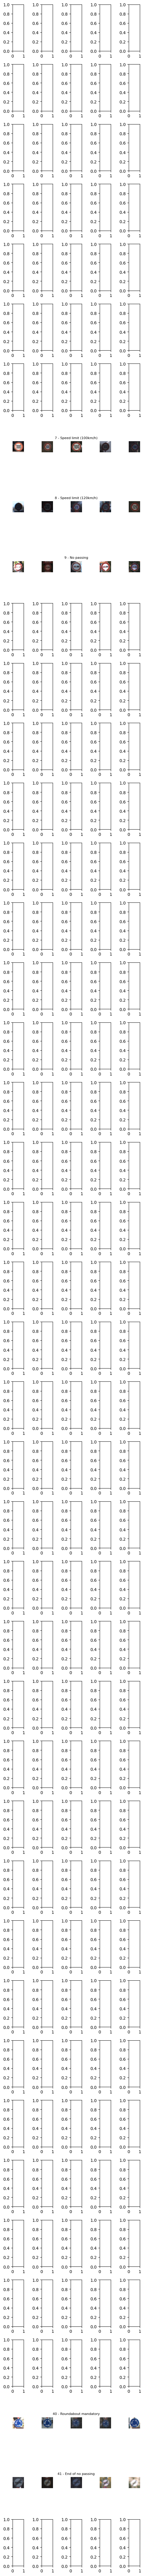

In [7]:
############## DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES #################
num_of_samples = []
cols = 5
fig, axs = plt.subplots(nrows=noOfClasses, ncols=cols, figsize=(5, noOfClasses * 2))
fig.tight_layout()

for j in range(noOfClasses):
    x_selected = X_train[y_train == j]
    if len(x_selected) == 0:
        continue  # skip if no samples for class
    num_of_samples.append(len(x_selected))

    for i in range(cols):
        rand_index = random.randint(0, len(x_selected) - 1)
        axs[j][i].imshow(x_selected[rand_index], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            # Show class name if available
            class_name = data[data['ClassId'] == j]['Name'].values
            title = f"{j} - {class_name[0]}" if len(class_name) > 0 else f"{j}"
            axs[j][i].set_title(title, fontsize=8)



In [8]:
###############PREPROCESSING THE IMAGES################

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

print("PreProcessing Started......")
X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
print("Train Preprocesssing completed.")
X_validation = np.array(list(map(preprocessing, X_validation)))
print("Test Preproccessing completed.")
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY

############################### ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)



PreProcessing Started......
Train Preprocesssing completed.
Test Preproccessing completed.


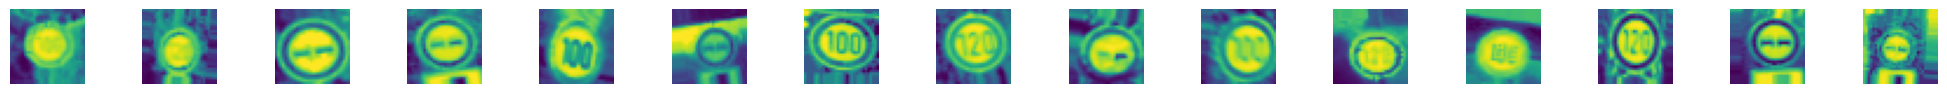

In [9]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,
                       batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


In [10]:
################### CONVOLUTION NEURAL NETWORK MODEL
def myModel(imageDimesions, noOfClasses):
    no_Of_Filters = 60
    size_of_Filter = (5, 5)# THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
       # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)# SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500 # NO. OF NODES IN HIDDEN LAYERS

    model = Sequential()
    model.add(Input(shape=(imageDimesions[0], imageDimesions[1], 1)))
    model.add(Conv2D(no_Of_Filters, size_of_Filter, activation='relu'))# ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add(Conv2D(no_Of_Filters, size_of_Filter, activation='relu'))
    model.add(MaxPool2D(pool_size=size_of_pool))# DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu'))
    model.add(MaxPool2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))# INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation='softmax'))# OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
#################TRAIN############## 
# Set your input image dimensions and number of classes
imageDimensions = (32, 32)  # Height, Width
noOfClasses = 43            # Number of traffic sign classes
model = myModel(imageDimensions,noOfClasses)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
steps_per_epoch_val=len(X_train)//batch_size_val
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                              steps_per_epoch=steps_per_epoch_val, epochs=epochs_val,
                              validation_data=(X_validation, y_validation), shuffle=1)


D:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.2667 - loss: 2.2813 - val_accuracy: 0.2960 - val_loss: 1.3348
Epoch 2/30
 1/41 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.2969 - loss: 1.4648

D:\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2969 - loss: 1.4648 - val_accuracy: 0.3004 - val_loss: 1.3329
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.3374 - loss: 1.3801 - val_accuracy: 0.5680 - val_loss: 1.2619
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4219 - loss: 1.2520 - val_accuracy: 0.5785 - val_loss: 1.2349
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.4252 - loss: 1.2159 - val_accuracy: 0.7429 - val_loss: 0.6162
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5156 - loss: 0.7949 - val_accuracy: 0.7220 - val_loss: 0.6112
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.5987 - loss: 0.8095 - val_accuracy: 0.7294 - val_loss: 0.5113
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6250 - loss: 0.6935 - val_accuracy: 0.7399 - val_loss: 0.4995
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.6519 - loss: 0.7436 - val_accuracy: 0.7653 - val_lo

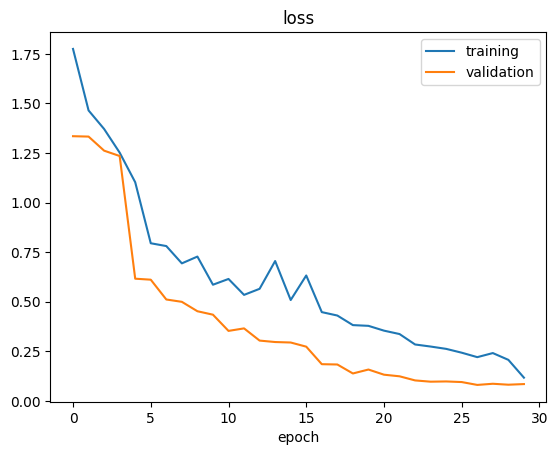

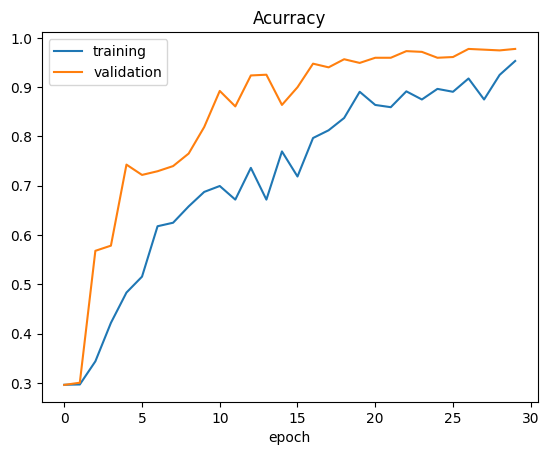

Test Score: 0.04300951212644577
Test Accuracy: 0.9904305934906006


In [13]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [14]:
from tensorflow.keras.models import load_model
model.save("traffic_model.keras")
print("Successfully Saved the model")

Successfully Saved the model


In [2]:
model = pickle.load(open("model_trained.p", "rb"))
model.save("Traffic_Sign_model.keras")

ModuleNotFoundError: No module named 'keras.src.saving.pickle_utils'